# Result summary
A summary of all bias correction methods (Table 1 in the paper - class-wise bias correction).

In [1]:
%matplotlib inline

import sys 
# add parental directory to Python path
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import pandas as pd
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

In [3]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 
              'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

# only consider 10 mutual classes between Openmic and IRMAS dataset
with open("../data/openmic-2018/openmic_classmap_10.json", "r") as f: 
    openmic_class_map = json.load(f)
    
with open("../data/class_align.json", "r") as f: 
    class_align = json.load(f)

with open("../data/genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("../data/instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

## original performance

In [24]:
def plot(ax, train_set, test_set, df, k):

    metric = 'roc_auc'
    df_visual1 = df[df['test_set']==test_set]
    df = df_visual1[df_visual1['train_set']==train_set]

    dist = .3
    y = np.arange(len(instrument_map)) * 5 + 1.5

    color = 'green'; embedding = 'vggish'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 
    color = 'orange'; embedding = 'openl3'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 - 1.5
    color = '#0e668b'; embedding = 'yamnet'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')

In [25]:
result_all = pd.read_csv('../results/result_linear_all.csv')
result_all['debias_method'] = [list(result_all['embedding'])[k].replace(list(result_all['embedding'])[k].split('-')[0], '') \
                               for k in range(len(result_all['embedding']))]
result_all['embedding'] = [list(result_all['embedding'])[k].split('-')[0] \
                               for k in range(len(result_all['embedding']))]
result_all['debias_method'] = ['original' if k=='' else k for k in result_all['debias_method']] 

df = result_all[result_all['debias_method']=='original']
df = df.reset_index(drop=True)

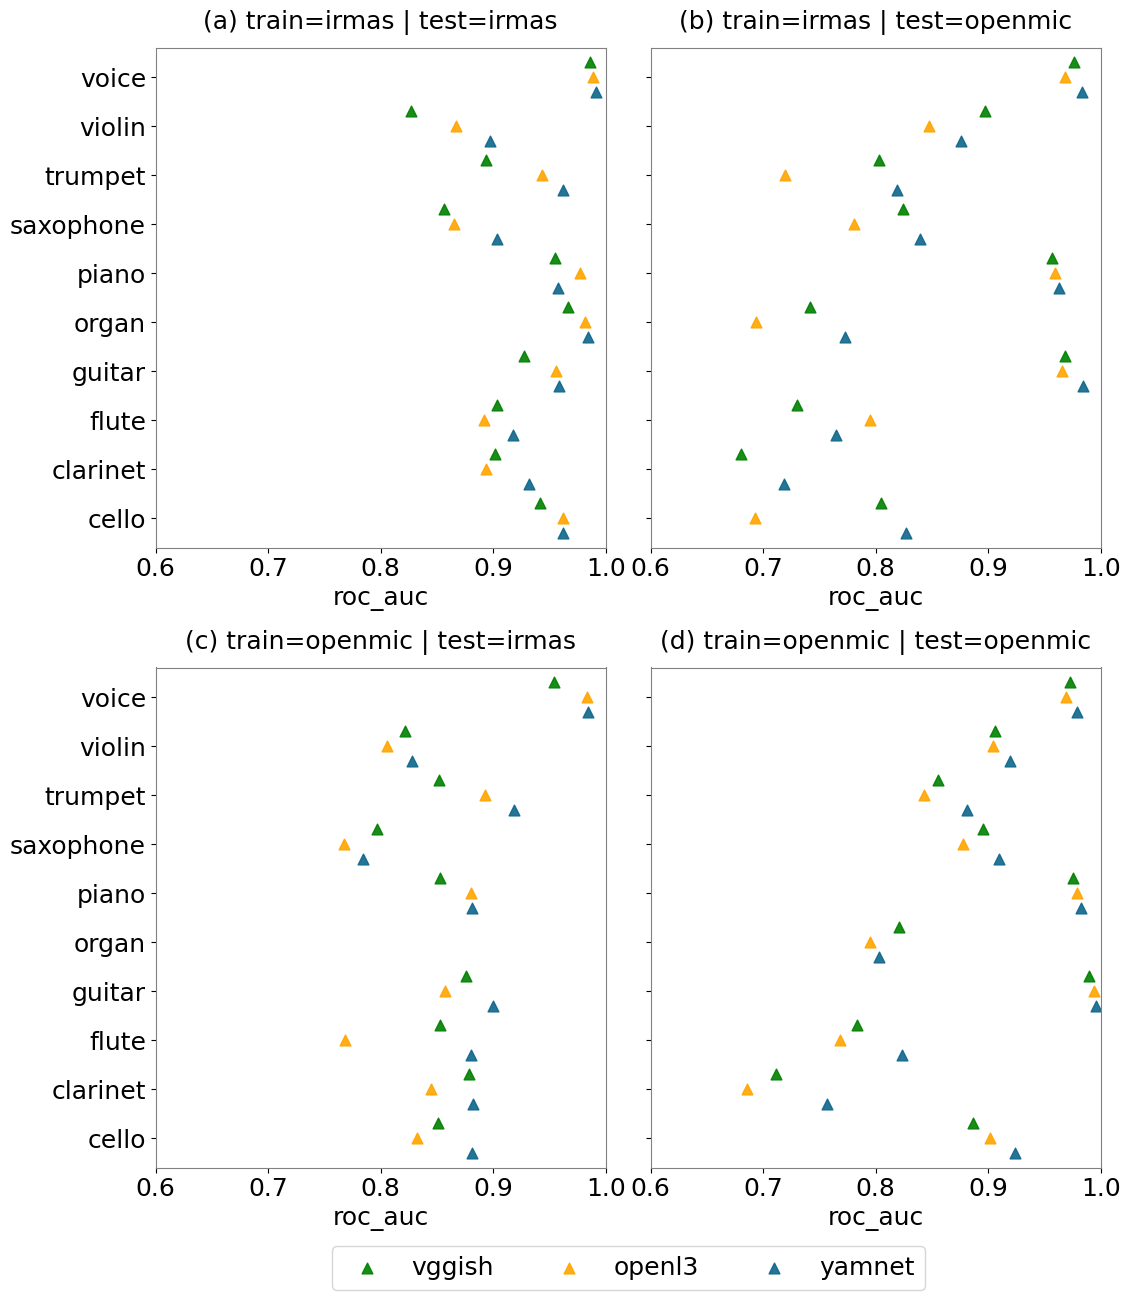

In [26]:
figure = plt.figure(figsize=(9,10))

size = 18
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'openmic'; test_set = 'irmas'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])

train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-3,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.27)) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])

train_set = 'irmas'; test_set = 'openmic'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48]); ax.set_yticklabels([]);

plt.tight_layout(); 
plt.savefig('../results/original_performance.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")

# Result summary

### Linear bias correction

In [11]:
df = pd.read_csv('../results/result_linear_all.csv')

In [12]:
embeddings = ['vggish', 'openl3', 'yamnet', 'vggish-lda', 'openl3-lda', 'yamnet-lda', 'vggish-mlda', 'openl3-mlda', 'yamnet-mlda']

case_mean_all = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])

cases = [['irmas', 'irmas'], ['openmic', 'openmic'], ['openmic', 'irmas'], ['irmas', 'openmic']]
for embedding in embeddings:
    for case in cases:
        train_set = case[0]
        test_set = case[1]
        case_mean = df.loc[(df['train_set'] == train_set) & (df['test_set'] == test_set) 
                        & (df['embedding'] == embedding)]['roc_auc'].values.mean()
        
        case_mean_item = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])
        case_mean_item['embedding'] = [embedding]
        case_mean_item['train_set'] = [train_set]
        case_mean_item['test_set'] = [test_set]
        case_mean_item['mean'] = [case_mean]

        case_mean_all = case_mean_all.append(case_mean_item)
        # print('{}: {} -> {}, mean = {}'.format(embedding, train_set, test_set, case_mean))

In [13]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [14]:
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [15]:
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mlda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mlda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [16]:
case_mean_all = case_mean_all.reset_index(drop=True)

In [17]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish, mean: [0.9159775670152692, 0.8795426308397019, 0.8281517016312634, 0.8381238345333191], change: [nan, nan, -0.08782586538400583, -0.04141879630638279]
openl3, mean: [0.9325875458792099, 0.8716086822582018, 0.8055627376673533, 0.8012630078353953], change: [nan, nan, -0.12702480821185658, -0.07034567442280648]
yamnet, mean: [0.9464977304079184, 0.897391623351162, 0.8501302963019303, 0.8546504075395533], change: [nan, nan, -0.09636743410598814, -0.04274121581160861]
vggish-lda, mean: [0.9159757843835784, 0.8799284302663853, 0.829947952063834, 0.8381621422404605], change: [nan, nan, 0.0017962504325705897, 3.830770714141618e-05]
openl3-lda, mean: [0.9325677510837126, 0.871621317325699, 0.8056333939806212, 0.8014961727020182], change: [nan, nan, 7.065631326785837e-05, 0.000233164866622948]
yamnet-lda, mean: [0.9464977304079184, 0.897391623351162, 0.8501307360556682, 0.8546504075395533], change: [nan, nan, 4.3975373797966455e-07, 0.0]
vggish-mlda, mean: [0.9144814500884042, 0.87978946

In [18]:
result_table = []
for embedding in ['vggish', 'openl3', 'yamnet']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])

In [19]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish, mean: [0.9159775670152692, 0.8795426308397019, 0.8281517016312634, 0.8381238345333191], change: [nan, nan, -0.08782586538400583, -0.04141879630638279]
openl3, mean: [0.9325875458792099, 0.8716086822582018, 0.8055627376673533, 0.8012630078353953], change: [nan, nan, -0.12702480821185658, -0.07034567442280648]
yamnet, mean: [0.9464977304079184, 0.897391623351162, 0.8501302963019303, 0.8546504075395533], change: [nan, nan, -0.09636743410598814, -0.04274121581160861]
vggish-lda, mean: [0.9159757843835784, 0.8799284302663853, 0.829947952063834, 0.8381621422404605], change: [nan, nan, 0.0017962504325705897, 3.830770714141618e-05]
openl3-lda, mean: [0.9325677510837126, 0.871621317325699, 0.8056333939806212, 0.8014961727020182], change: [nan, nan, 7.065631326785837e-05, 0.000233164866622948]
yamnet-lda, mean: [0.9464977304079184, 0.897391623351162, 0.8501307360556682, 0.8546504075395533], change: [nan, nan, 4.3975373797966455e-07, 0.0]
vggish-mlda, mean: [0.9144814500884042, 0.87978946

In [20]:
df = pd.DataFrame(columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2'])
embeddings = ['vggish', 'openl3', 'yamnet'] + ['vggish-lda', 'openl3-lda', 'yamnet-lda'] + \
                    ['vggish-mlda', 'openl3-mlda', 'yamnet-mlda']
for k in range(len(result_table)):
    new_line = [embeddings[k]] + list(np.round(np.array(result_table[k]) * 100, 2))

    df = df.append(pd.DataFrame([new_line], 
        columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2']), 
        ignore_index=True)
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic,change1,change2
0,vggish,91.60,87.95,82.82,83.81,-8.78,-4.14
1,openl3,93.26,87.16,80.56,80.13,-12.70,-7.03
2,yamnet,94.65,89.74,85.01,85.47,-9.64,-4.27
3,vggish-lda,91.60,87.99,82.99,83.82,0.18,0.00
4,openl3-lda,93.26,87.16,80.56,80.15,0.01,0.02
5,yamnet-lda,94.65,89.74,85.01,85.47,0.00,0.00
6,vggish-mlda,91.45,87.98,82.70,83.30,-0.11,-0.51
7,openl3-mlda,93.11,87.16,80.67,79.93,0.12,-0.20
8,yamnet-mlda,94.65,89.74,85.01,85.47,-0.00,0.00


In [21]:
df['change1'] = ['(' + str(item) + ')' for item in df['change1']]
df['change2'] = ['(' + str(item) + ')' for item in df['change2']]
df['openmic-irmas'] = [str(df['openmic-irmas'][k]) + ' ' + df['change1'][k] for k in range(len(df['change1']))]
df['irmas-openmic'] = [str(df['irmas-openmic'][k]) + ' ' + df['change2'][k] for k in range(len(df['change2']))]
df = df.drop(columns=['change1', 'change2'])
df # in Table 1: classw-ise bias correction for linear case

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic
0,vggish,91.60,87.95,82.82 (-8.78),83.81 (-4.14)
1,openl3,93.26,87.16,80.56 (-12.7),80.13 (-7.03)
2,yamnet,94.65,89.74,85.01 (-9.64),85.47 (-4.27)
3,vggish-lda,91.60,87.99,82.99 (0.18),83.82 (0.0)
4,openl3-lda,93.26,87.16,80.56 (0.01),80.15 (0.02)
5,yamnet-lda,94.65,89.74,85.01 (0.0),85.47 (0.0)
6,vggish-mlda,91.45,87.98,82.7 (-0.11),83.3 (-0.51)
7,openl3-mlda,93.11,87.16,80.67 (0.12),79.93 (-0.2)
8,yamnet-mlda,94.65,89.74,85.01 (-0.0),85.47 (0.0)


In [22]:
df.to_csv('../results/result_table_linear.csv', index=False)

### performance change plot

In [ ]:
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(instrument_map)) * 5 + 1.7,
                   'openl3': np.arange(len(instrument_map)) * 5,
                   'yamnet': np.arange(len(instrument_map)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-mlda']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = list(df[df['embedding']==bias_lir_nonlir[1]][metric])
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title('train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')

In [ ]:
df = pd.read_csv('../results/result_linear_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(6,7))

size = 12
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'openmic'; test_set = 'irmas'
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48])

# Creating legend with color box
patch1 = mpatches.Patch(color='green', label='vggish')
patch2 = mpatches.Patch(color='orange', label='openl3')
patch3 = mpatches.Patch(color='#0e668b', label='yamnet')
plt.legend(handles=[patch1, patch2, patch3], loc="lower center", ncol=3, bbox_to_anchor=(1, -0.27))
plt.grid(True)

train_set = 'openmic'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'irmas'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48]); 
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
# plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('../results/irmas_openmic_lda.pdf', bbox_inches = "tight")

### Nonlinear bias correction

In [40]:
df1 = pd.read_csv('../results/result_linear_all.csv')
df2 = pd.read_csv('../results/result_nonlinear_all.csv')

df = df1.append(df2)

In [41]:
embeddings = ['vggish', 'openl3', 'yamnet', 'vggish-k', 'openl3-k', 'yamnet-k', 
              'vggish-klda', 'openl3-klda', 'yamnet-klda', 'vggish-mklda', 'openl3-mklda', 'yamnet-mklda']

case_mean_all = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])

cases = [['irmas', 'irmas'], ['openmic', 'openmic'], ['openmic', 'irmas'], ['irmas', 'openmic']]
for embedding in embeddings:
    for case in cases:
        train_set = case[0]
        test_set = case[1]
        case_mean = df.loc[(df['train_set'] == train_set) & (df['test_set'] == test_set) 
                        & (df['embedding'] == embedding)]['roc_auc'].values.mean()
        
        case_mean_item = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])
        case_mean_item['embedding'] = [embedding]
        case_mean_item['train_set'] = [train_set]
        case_mean_item['test_set'] = [test_set]
        case_mean_item['mean'] = [case_mean]

        case_mean_all = case_mean_all.append(case_mean_item)
        # print('{}: {} -> {}, mean = {}'.format(embedding, train_set, test_set, case_mean))
# case_mean_all = case_mean_all.reset_index(drop=True)

In [42]:
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-k','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-k','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [43]:
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-klda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-klda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [44]:
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mklda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mklda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [45]:
case_mean_all = case_mean_all.reset_index(drop=True)

In [46]:
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish-k, mean: [0.9223607610671773, 0.880771280705835, 0.8256957160922109, 0.8367100423561636], change: [nan, nan, -0.002455985539052463, -0.0014137921771554263]
openl3-k, mean: [0.9388933329670728, 0.8790862716909598, 0.7946325157307582, 0.8123155767501957], change: [nan, nan, -0.010930221936595097, 0.011052568914800442]
yamnet-k, mean: [0.9382648837047963, 0.8923530287559623, 0.8587278564221423, 0.8455710492142406], change: [nan, nan, 0.008597560120212067, -0.009079358325312703]
vggish-klda, mean: [0.9223526361271445, 0.88077652951419, 0.8257645308509469, 0.8366861597324977], change: [nan, nan, -0.002387170780316472, -0.0014376748008213536]
openl3-klda, mean: [0.9388987384653072, 0.8784334528108525, 0.7902858023263346, 0.812320292317988], change: [nan, nan, -0.015276935341018705, 0.011057284482592689]
yamnet-klda, mean: [0.9382608869680009, 0.8923363663386492, 0.858713345751276, 0.8455721698156697], change: [nan, nan, 0.008583049449345737, -0.009078237723883609]
vggish-mklda, mean: 

In [47]:
result_table = []
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])

In [48]:
df = pd.DataFrame(columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2'])
embeddings = ['vggish-k', 'openl3-k', 'yamnet-k'] + ['vggish-klda', 'openl3-klda', 'yamnet-klda'] + \
                    ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']
for k in range(len(result_table)):
    new_line = [embeddings[k]] + list(np.round(np.array(result_table[k]) * 100, 2))

    df = df.append(pd.DataFrame([new_line], 
        columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2']), 
        ignore_index=True)

In [49]:
df['change1'] = ['(' + str(item) + ')' for item in df['change1']]
df['change2'] = ['(' + str(item) + ')' for item in df['change2']]
df['openmic-irmas'] = [str(df['openmic-irmas'][k]) + ' ' + df['change1'][k] for k in range(len(df['change1']))]
df['irmas-openmic'] = [str(df['irmas-openmic'][k]) + ' ' + df['change2'][k] for k in range(len(df['change2']))]
df = df.drop(columns=['change1', 'change2'])
df # in Table 1: class-wise bias correction for nonlinear case

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic
0,vggish-k,92.24,88.08,82.57 (-0.25),83.67 (-0.14)
1,openl3-k,93.89,87.91,79.46 (-1.09),81.23 (1.11)
2,yamnet-k,93.83,89.24,85.87 (0.86),84.56 (-0.91)
3,vggish-klda,92.24,88.08,82.58 (-0.24),83.67 (-0.14)
4,openl3-klda,93.89,87.84,79.03 (-1.53),81.23 (1.11)
5,yamnet-klda,93.83,89.23,85.87 (0.86),84.56 (-0.91)
6,vggish-mklda,92.22,88.15,82.42 (-0.39),83.7 (-0.11)
7,openl3-mklda,93.88,87.88,79.56 (-1.0),81.2 (1.07)
8,yamnet-mklda,93.79,89.19,85.72 (0.71),84.43 (-1.04)


In [51]:
df.to_csv('../results/result_table_nonlinear.csv', index=False)

In [52]:
df_linear = pd.read_csv('../results/result_table_linear.csv')
df = df_linear.append(df)
df.to_csv('../results/result_table_all.csv', index=False)

In [53]:
df_linear = pd.read_csv('../results/result_linear_all.csv')
df_nonlinear = pd.read_csv('../results/result_nonlinear_all.csv')
df = df_linear.append(df_nonlinear)
df.to_csv('../results/result_all.csv', index=False)